# German Traffic Sign Image Recognition 

In [7]:
import os
import time as time

import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from PIL import Image
import time
from datetime import timedelta
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import skimage.morphology as morp
from skimage.filters import rank

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout # new!
from keras.layers.normalization import BatchNormalization # new!
from keras import regularizers # new! 
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D # new!
from keras.callbacks import ModelCheckpoint

import cv2



In [8]:
import pickle
training_file = "Traffic_Signals/train.p"
testing_file = "Traffic_Signals/test.p"
validation_file = "Traffic_Signals/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid , y_valid = valid['features'], valid['labels']



## Understand the shape of the datasets



In [3]:
# Understand the data
print("Training Set:", len(X_train))
print("Test Set:", len(y_test))
print("Validation Set:", len(X_valid))
print("Image Dimensions:", np.shape(X_train[1]))
print("Number of classes:", len(np.unique(y_train)))
n_classes = len(np.unique(y_train))


Training Set: 34799
Test Set: 12630
Validation Set: 4410
Image Dimensions: (32, 32, 3)
Number of classes: 43


# Basic Descriptive analysis. 

## Look for class bias 

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
   690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
   480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
   210]]


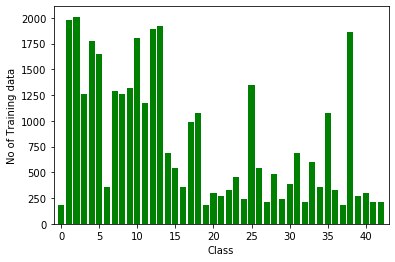

 
We can definitely see class bias issue as certain classes are under represented
 
 
Traffic Sign Images


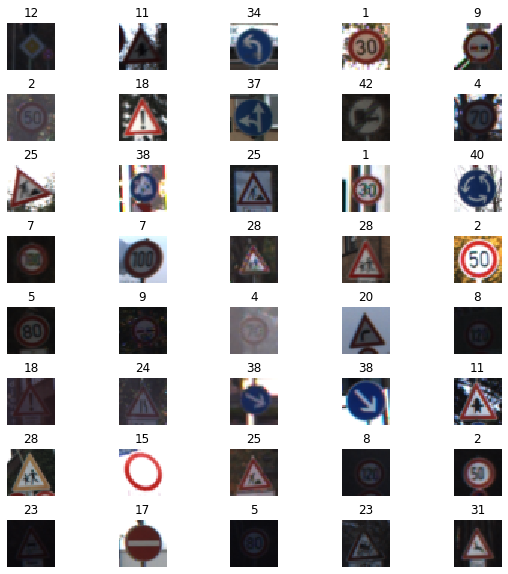

In [4]:
# Basic Descriptive analysis


# Checking for class bias 

unique_elements, counts_elements = np.unique(y_train, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

pyplot.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
pyplot.xlabel('Class')
pyplot.ylabel('No of Training data')
pyplot.xlim([-1, 43])

pyplot.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

# View few images

import matplotlib.pyplot as plt
import random

%matplotlib inline
print(" ")
print(" ")
print("Traffic Sign Images")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])
    
    



## Model Testing without any preprocessing - 

## Establishing Baseline

# Neural Network Architecture

In [5]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))


In [6]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)              

In [7]:
X_train_baseline = X_train.reshape(len(X_train), 32*32*3).astype('float32')
X_valid_baseline = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, n_classes)
y_valid_baseline = keras.utils.to_categorical(y_valid, n_classes)

In [8]:
model.fit(X_train_baseline, y_train_baseline, batch_size=128, epochs=100, verbose=1, validation_data=(X_valid_baseline, y_valid_baseline))

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 7s 200us/step - loss: 2.5859 - accuracy: 0.3016 - val_loss: 1.7557 - val_accuracy: 0.4728
Epoch 2/100
34799/34799 [==============================] - 6s 165us/step - loss: 1.3201 - accuracy: 0.5926 - val_loss: 1.2773 - val_accuracy: 0.6218
Epoch 3/100
34799/34799 [==============================] - 6s 161us/step - loss: 0.9347 - accuracy: 0.7144 - val_loss: 1.2950 - val_accuracy: 0.6005
Epoch 4/100
34799/34799 [==============================] - 5s 151us/step - loss: 0.7618 - accuracy: 0.7680 - val_loss: 0.8759 - val_accuracy: 0.7034
Epoch 5/100
34799/34799 [==============================] - 6s 174us/step - loss: 0.6391 - accuracy: 0.8052 - val_loss: 0.8253 - val_accuracy: 0.7420
Epoch 6/100
34799/34799 [==============================] - 5s 153us/step - loss: 0.5857 - accuracy: 0.8226 - val_loss: 0.7684 - val_accuracy: 0.7717
Epoch 7/100
34799/34799 [==============================] 

In [9]:
X_test_baseline = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_test_baseline = keras.utils.to_categorical(y_test, n_classes)

In [10]:
Pred = model.evaluate(X_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Baseline ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - Baseline 
 
loss- 0.99
accuracy- 0.86


# Data Preprocessing

## Data Augmentation

In [11]:
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    #Geometric Transformation
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img


## Increase training set by augmentation and making all class size similar

In [12]:
classes = 43

X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug
        
  
    

## Check class bias after augmentation

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000]]


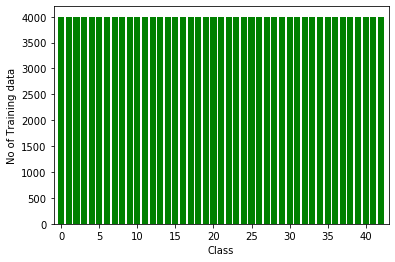

In [13]:
unique_elements, counts_elements = np.unique(y_train_final, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

pyplot.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
pyplot.xlabel('Class')
pyplot.ylabel('No of Training data')
pyplot.xlim([-1, 43])

pyplot.show()

## Shape of the datasets after data augmentation

In [14]:
print(len(X_train))
print(len(X_train_final))
print(len(y_train))
print(len(y_train_final))

34799
172000
34799
172000


## View images after data augmentation

 
 
Let's view few images to understand our transformations


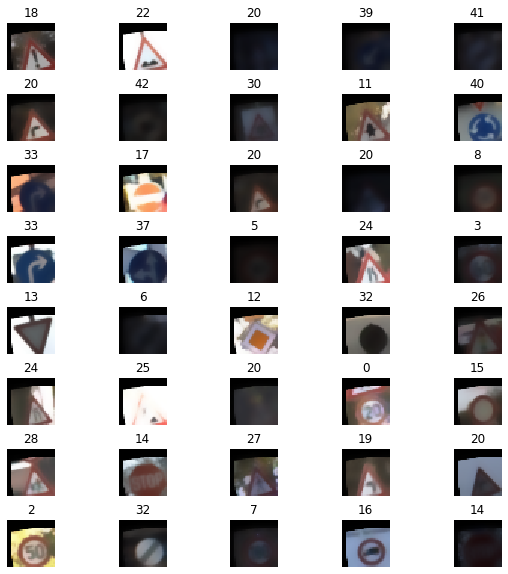

In [15]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
print(" ")
print(" ")
print("Let's view few images to understand our transformations")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])
    

## Model Testing after Augmentation

In [16]:
X_train_aug = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_valid_aug = X_valid.reshape(len(X_valid), 32*32*3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_aug = keras.utils.to_categorical(y_valid, n_classes)

In [21]:
filepath="German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
model.fit(X_train_aug, y_train_aug, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_aug, y_valid_aug))

Train on 172000 samples, validate on 4410 samples
Epoch 1/100
172000/172000 [==============================] - 30s 175us/step - loss: 1.4173 - accuracy: 0.6016 - val_loss: 0.7408 - val_accuracy: 0.8070
Epoch 2/100
   896/172000 [..............................] - ETA: 27s - loss: 0.9810 - accuracy: 0.6864

C:\Python38\Anaconda3\envs\py3-TF2.0\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


172000/172000 [==============================] - 27s 157us/step - loss: 0.7926 - accuracy: 0.7556 - val_loss: 0.6981 - val_accuracy: 0.8295
Epoch 3/100
172000/172000 [==============================] - 24s 139us/step - loss: 0.6373 - accuracy: 0.8020 - val_loss: 0.7647 - val_accuracy: 0.8186
Epoch 4/100
172000/172000 [==============================] - 26s 153us/step - loss: 0.5526 - accuracy: 0.8277 - val_loss: 0.6464 - val_accuracy: 0.8519
Epoch 5/100
172000/172000 [==============================] - 25s 146us/step - loss: 0.5015 - accuracy: 0.8436 - val_loss: 0.6706 - val_accuracy: 0.8472
Epoch 6/100
172000/172000 [==============================] - 28s 161us/step - loss: 0.4574 - accuracy: 0.8575 - val_loss: 0.6476 - val_accuracy: 0.8528
Epoch 7/100
172000/172000 [==============================] - 26s 152us/step - loss: 0.4276 - accuracy: 0.8662 - val_loss: 0.6434 - val_accuracy: 0.8390
Epoch 8/100
172000/172000 [==============================] - 27s 157us/step - loss: 0.4088 - accurac

In [19]:
X_test_aug = X_test.reshape(len(X_test), 32*32*3).astype('float32')
y_test_aug = keras.utils.to_categorical(y_test, n_classes)

In [22]:
model.load_weights("German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

OSError: Unable to open file (unable to open file: name = 'German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [23]:
Pred = model.evaluate(X_test_aug, y_test_aug, verbose=0)
print("Dense fully connected network results on the test data - After Data Augmentation ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - After Data Augmentation 
 
loss- 0.91
accuracy- 0.87


# Gray Scaling

 
 
Let's view few images to familiarize


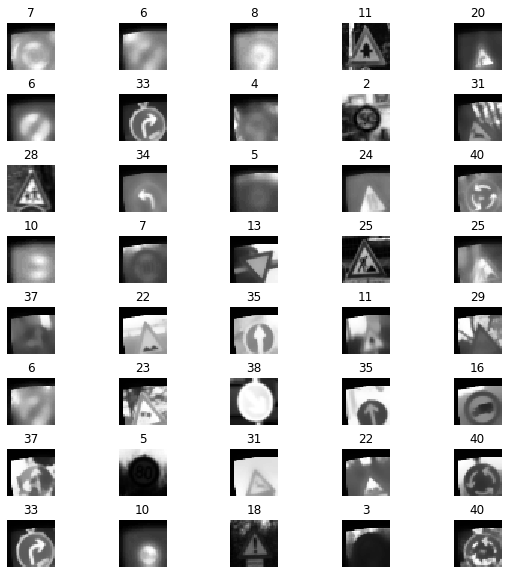

In [24]:
def gray_scale(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images_data = list(map(gray_scale, X_train_final))


%matplotlib inline
print(" ")
print(" ")
print("Let's view few images to familiarize")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(gray_images_data))
    image = gray_images_data[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap='gray')
    axs[i].set_title(y_train_final[index])
  



 
 
Let's view few images after applying local histogram equilization and Gray scaling


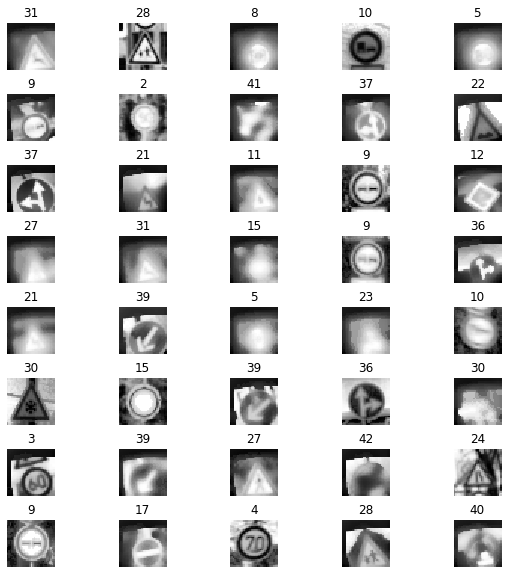

In [25]:
def local_histo_equalize(image):
    
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


local_histo = np.array(list(map(local_histo_equalize, gray_images_data)))
%matplotlib inline
print(" ")
print(" ")
print("Let's view few images after applying local histogram equilization and Gray scaling")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(local_histo))
    image = local_histo[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap = 'gray')
    axs[i].set_title(y_train_final[index])
 

In [26]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = np.divide(img,255)
    normalized_images = normalized_images[..., None]
    return normalized_images

## Apply Grayscaling and local histogram equalization to the training and the validation data

In [27]:
X_train_preprocessed = preprocess(X_train_final)
X_valid_preprocessed = preprocess(X_valid)

In [28]:
X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32*32*1).astype('float32')


In [29]:
y_train_final_dn = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_final_dn = keras.utils.to_categorical(y_valid, n_classes)


## Check the shape of the datasets after all preprocessing

In [30]:
print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)

(172000, 1024)
(4410, 1024)
(172000, 43)
(4410, 43)


# Compile  and fit the model after preprocessing

## Neural network architecture after grayscaling

In [10]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*1,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))


NameError: name 'n_classes' is not defined

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Save model with Checkpoint

In [33]:
filepath="German_Traffic_DenseNetworkModel_final.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [34]:
model.fit(X_train_preprocessed_dn, y_train_final_dn, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_preprocessed_dn, y_valid_final_dn))

Train on 172000 samples, validate on 4410 samples
Epoch 1/100
172000/172000 [==============================] - 25s 148us/step - loss: 1.7034 - accuracy: 0.5140 - val_loss: 1.7923 - val_accuracy: 0.4469
Epoch 2/100
  1024/172000 [..............................] - ETA: 21s - loss: 1.1405 - accuracy: 0.6611

C:\Python38\Anaconda3\envs\py3-TF2.0\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


172000/172000 [==============================] - 17s 98us/step - loss: 0.9394 - accuracy: 0.7153 - val_loss: 1.2244 - val_accuracy: 0.6238
Epoch 3/100
172000/172000 [==============================] - 12s 67us/step - loss: 0.7720 - accuracy: 0.7634 - val_loss: 0.9834 - val_accuracy: 0.6807
Epoch 4/100
172000/172000 [==============================] - 12s 68us/step - loss: 0.6872 - accuracy: 0.7899 - val_loss: 0.8717 - val_accuracy: 0.7351
Epoch 5/100
172000/172000 [==============================] - 12s 69us/step - loss: 0.6319 - accuracy: 0.8053 - val_loss: 0.9001 - val_accuracy: 0.7091
Epoch 6/100
172000/172000 [==============================] - 13s 76us/step - loss: 0.5904 - accuracy: 0.8170 - val_loss: 0.8184 - val_accuracy: 0.7365
Epoch 7/100
172000/172000 [==============================] - 12s 68us/step - loss: 0.5698 - accuracy: 0.8247 - val_loss: 0.7827 - val_accuracy: 0.7696
Epoch 8/100
172000/172000 [==============================] - 12s 72us/step - loss: 0.5409 - accuracy: 0.83

## prepare test data for final results

In [35]:
## Prepare the Test data with all the preprocessing

X_test_preprocessed = preprocess(X_test)
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')
y_test_final_dn = keras.utils.to_categorical(y_test, n_classes)


## Load the best model from the validation data results

In [29]:
model.load_weights("German_Traffic_DenseNetworkModel_final.hdf5")

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
Pred = model.evaluate(X_test_preprocessed_dn, y_test_final_dn, verbose=0)
print("Dense fully connected network results on the test data")
print(" ")
print("%s- %.2f%%" % (model.metrics_names[0], Pred[0]*100))
print("%s- %.2f%%" % (model.metrics_names[1], Pred[1]*100))

Dense fully connected network results on the test data
 
loss- 61.72%
accuracy- 84.82%


##  Convolutional Networks

In [38]:
# Prepare data for Conv nets
X_train_preprocessed_cn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32,32,1).astype('float32')
X_valid_preprocessed_cn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32,32,1).astype('float32')
X_test_preprocessed_cn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32,32,1).astype('float32')


In [39]:
y_train_final_cn = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_final_cn = keras.utils.to_categorical(y_valid, n_classes)
y_test_final_cn = keras.utils.to_categorical(y_test, n_classes)


In [9]:
model_conv = Sequential()
model_conv.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 1)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Dropout(0.25))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Dropout(0.5))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(n_classes, activation='softmax'))


NameError: name 'model' is not defined

In [41]:
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
filepath="German_Traffic_ConvNetworkModel.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

In [ ]:
model_conv.fit(X_train_preprocessed_cn, y_train_final_cn, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list_conv,validation_data=(X_valid_preprocessed_cn, y_valid_final_cn))

Train on 172000 samples, validate on 4410 samples
Epoch 1/100
172000/172000 [==============================] - 640s 4ms/step - loss: 1.5909 - accuracy: 0.5415 - val_loss: 0.4544 - val_accuracy: 0.8574
Epoch 2/100


C:\Python38\Anaconda3\envs\py3-TF2.0\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


172000/172000 [==============================] - 654s 4ms/step - loss: 0.4795 - accuracy: 0.8488 - val_loss: 0.1879 - val_accuracy: 0.9506
Epoch 3/100
172000/172000 [==============================] - 652s 4ms/step - loss: 0.3180 - accuracy: 0.9004 - val_loss: 0.0888 - val_accuracy: 0.9773
Epoch 4/100
172000/172000 [==============================] - 653s 4ms/step - loss: 0.2504 - accuracy: 0.9225 - val_loss: 0.0796 - val_accuracy: 0.9762
Epoch 5/100
172000/172000 [==============================] - 652s 4ms/step - loss: 0.2097 - accuracy: 0.9353 - val_loss: 0.0663 - val_accuracy: 0.9800
Epoch 6/100
172000/172000 [==============================] - 651s 4ms/step - loss: 0.1816 - accuracy: 0.9442 - val_loss: 0.0551 - val_accuracy: 0.9830
Epoch 7/100
172000/172000 [==============================] - 651s 4ms/step - loss: 0.1669 - accuracy: 0.9492 - val_loss: 0.0512 - val_accuracy: 0.9859
Epoch 8/100
172000/172000 [==============================] - 652s 4ms/step - loss: 0.1524 - accuracy: 0.95

In [1]:
model_conv.load_weights("German_Traffic_ConvNetworkModel.hdf5")
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'model_conv' is not defined

In [ ]:
Pred_conv = model_conv.evaluate(X_test_preprocessed_cn, y_test_final_cn, verbose=0)
print("Dense fully connected network results on the test data")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred_conv[1]))